In [73]:
import glob
import fsl.utils.image.resample as resample
import fsl.data.atlases         as atlases
import fsl.data.image           as fslimage
import fsl.transform.affine     as affine
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
from nibabel.nifti1 import Nifti1Image
from PIL import Image
from   fsl.utils.platform import   platform
fsldir = os.path.join(platform.fsldir,'data','atlases')
fslPaths = sorted(glob.glob(os.path.join(fsldir, '*.xml')))

[AtlasDescription(cerebellum_mniflirt),
 AtlasDescription(cerebellum_mnifnirt),
 AtlasDescription(harvardoxford-cortical),
 AtlasDescription(harvardoxford-subcortical),
 AtlasDescription(smatt),
 AtlasDescription(jhu-labels),
 AtlasDescription(jhu-tracts),
 AtlasDescription(juelich),
 AtlasDescription(marsparietalparcellation),
 AtlasDescription(marstpjparcellation),
 AtlasDescription(mni),
 AtlasDescription(neubertventralfrontalparcellation),
 AtlasDescription(thalamus),
 AtlasDescription(striatum-connectivity-3sub),
 AtlasDescription(striatum-connectivity-7sub),
 AtlasDescription(striatum-structural),
 AtlasDescription(salletdorsalfrontalparcellation),
 AtlasDescription(stn),
 AtlasDescription(talairach),
 AtlasDescription(xtract),
 AtlasDescription(xtract_mac)]

# Working with FSLpy

This notebook is for working with FSL by using the Python wrapper FSLpy. The documentation for the proper use of this wrapper can be found in the <a href="https://open.win.ox.ac.uk/pages/fsl/fslpy/index.html#"> Official Link </a> from FSLpy. The documentation for installation and usage of FSL utilities, is available through the FMRIB group webpage, specifically the <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL"> FSL installation</a> portal. 

To find the installation path of FSL in a Linux or macOS computer, just use $FSLDIR on the terminal. With fslpy, we can do the same with fsl.utils.platform.fsldir, which is going to give us the exact same output as $FSLDIR on zsh or bash.

In [87]:
!$FSLDIR

zsh:1: permission denied: /usr/local/fsl


In [88]:
platform.fsldir

'/usr/local/fsl'

To add all the atlases, just add them to the atlases object by looking into the FSL official directory. 

In [4]:
for file in fslPaths:
    atlases.addAtlas(file)
print("The Available Atlases on the $FSLDIR/data/atlases directory, are:")
atlases.listAtlases()

## Loading the Atlases

Now, we can look into the different atlases, one first approach is to look into the already segmented volumes, which are stored in the /data/atlases directory. These atlases have an already segmented object, with different anatomical parts of the brain. In the case of MNI152, we can see the mean volumes of 9 different manually segmented (by experts, this is considered the "ground truth") parts of the brain. The "mean" volumes are taken from the analysis of 152 brains of developed adults. 

If we perform an image registration approach with a patient with the MNI brain, we will be able to always have the same location in all the patients. Also, as the MNI atlas is in the "Standard Space" (as we can check in the documentation of any different neurological imaging suite, it is a space that is centered in the center of mass of the MNI + the voxel distance is 1 mm from each other, i.e. it has physical interpretation...), it is easier to find where is each of the brain structures on the images.

Let's look at the segmented image, and the estructural image.

### Segmented Image:



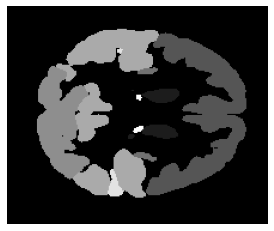

In [90]:
MNI = atlases.loadAtlas('mni', resolution=1.0, loadSummary=True).nibImage.get_fdata()
MNI.shape
plt.imshow(MNI[:,:,91], cmap='gray')
plt.axis('off')
plt.show()

### Structural Image

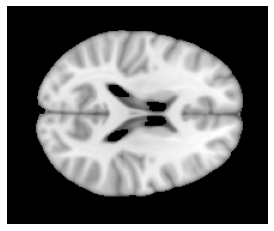

In [89]:
MNI_map = nib.load(os.path.join(platform.fsldir,'data','standard','MNI152_T1_1mm_brain.nii.gz')).get_fdata()
plt.imshow(MNI_map[:,:,91], cmap='gray')
plt.axis('off')
plt.show()